# Resources

- [Prof. Steven K. Krueger's notes on saturation adjustment](http://www.inscc.utah.edu/~krueger/5200/Saturation_Adjustment.pdf)
- [Peter Bechtold's notes at ECMWF](http://old.ecmwf.int/newsevents/training/lecture_notes/pdf_files/PARAM/Atmospheric_Thermodynamics.pdf)

In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plot

from ccfm.cloud_model import ccfm__native__pylib
from ccfm.cloud_model import ccfm_native
%matplotlib inline

In [72]:
# Heat capacities
cp_d = 1004.64 # J/kg/K
cv_d = 717.60 # J/kg/K
cp_v = 1874.0 # J/kg/K
cv_v = 1402.5 # J/kg/K

# Teten's formula for saturation vapour pressure (constants from Bechtold's notes)
# over liquid water
p0vs = 611.2  # [Pa]
a0_lq = 17.67
a1_lq = -32.19
a0_ice = 22.587
a1_ice = 0.7

# CCFM constants
p0vs = 610.78
a0_lq = 17.269
a1_lq = -35.86
a0_ice = 21.875
a1_ice = -7.66

pv_sat_lq = lambda T: p0vs*np.exp((a0_lq*(T-273.15)/(T+a1_lq)))
# over ice
pv_sat_ice = lambda T: p0vs*np.exp((a0_ice*(T-273.15)/(T+a1_ice)))

def pv_sat(T):
    v = np.zeros(np.array(T).shape)
    
    if v.shape == ():
        if T > 273.15:
            return pv_sat_lq(T)
        else:
            return pv_sat_ice(T)
    else:
        T = np.array(T)
        idx_liquid = np.array(T) > 273.15
        idx_ice = idx_liquid == False
        v[idx_liquid] = pv_sat_lq(T[idx_liquid])
        v[idx_ice] = pv_sat_ice(T[idx_ice])
        return v
    
# pv_sat = lambda T: 611.2*np.exp((17.67*(T-273.15)/(T-32.19)))


Rd = cp_d - cv_d
Rv = cp_v - cv_v

epsilon = Rd/Rv

cp = lambda qv: (1-qv)*cp_d + qv*cp_v
cv = lambda qv: (1-qv)*cv_d + qv*cv_v
R = lambda qv: cp(qv) - cv(qv)
kappa = lambda qv: R(qv)/cp(qv)


# Constants from CCFM
Rd = 287.05
Rv = 461.51
epsilon = Rd/Rv
cp = lambda qv: 1005.46


In [67]:
qv = lambda T, p, pv: (epsilon*pv)/(p-(1-epsilon)*pv)
def qv_sat(T, p):
    pv = pv_sat(T)
    return qv(T=T, p=p, pv=pv)

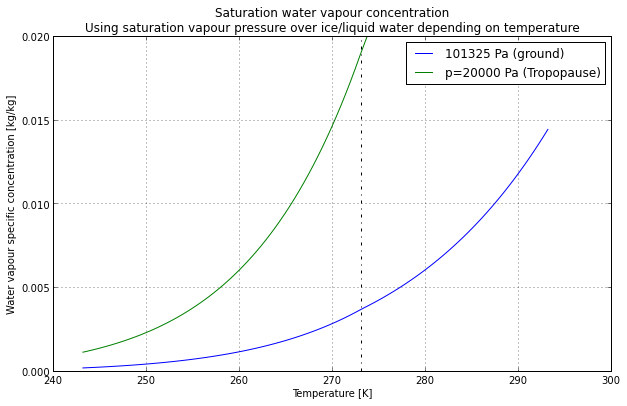

In [68]:
T = np.linspace(273.15-30., 273.15+20., 100)  # K
p0 = 101325  # Pa

plot.figure(figsize=(10,6))
plot.plot(T, qv_sat(T=T, p=p0), label='%g Pa (ground)' % p0)
plot.plot(T, qv_sat(T=T, p=200e2), label='p=%g Pa (Tropopause)' % 200e2)

plot.ylim(None, 0.02)
plot.grid(True)
plot.xlabel('Temperature [K]')
plot.axvline(273.15, linestyle='-.', color='black')
plot.ylabel('Water vapour specific concentration [kg/kg]')
plot.title('Saturation water vapour concentration\nUsing saturation vapour pressure over ice/liquid water depending on temperature')
plot.legend()

# Saturation adjustment integration

In [69]:
RH_0 = 0.9
T0 = 293.15  # [K]
dz = 10. # [m]
g = 9.8

z0 = 0.0  # [m]
z_max = 10e3  # [m]

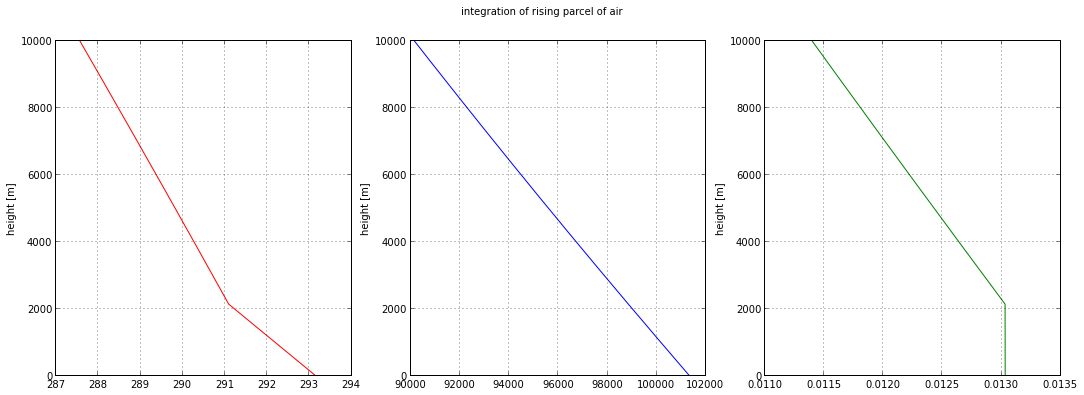

In [70]:
T_ = [T0, ]
p_ = [p0, ]
qv_ = [qv_sat(T=T0, p=p0)*RH_0,]

z_ = [z0,]

# p=rho*R*T
def rho(p,T,qv):
    R_ = R(qv)
    return p/(R_*T)
                       
dpdz = lambda p, T, qv: -rho(p,T,qv)*g
dTdz = lambda qv: -g/cp(qv)


def moist_adjust(T, p, qv):
    Tnew = np.array(float(T))
    qv_new = np.array(float(qv))
    ccfm_native.mo_ccfm_cloudbase.moist_adjust(tem=Tnew, q_v=qv_new, prs=p)
    
    return Tnew, qv_new

while z_[-1] < z_max:
    p_old, T_old, qv_old = p_[-1], T_[-1], qv_[-1]
    
    z_new = z_[-1] + dz
    p_new = p_old + dpdz(p=p_old, T=T_old, qv=qv_old)
    T_new = T_old + dTdz(qv=qv_old)
    qv_new = qv_old  # no microphysics
    
    T_new, qv_new = moist_adjust(T=T_new, p=p_new, qv=qv_new)

    qv_.append(qv_new)
    T_.append(T_new)
    p_.append(p_new)
    z_.append(z_new)

T_ = np.array(T_)
p_ = np.array(p_)
z_ = np.array(z_)
qv_ = np.array(qv_)

plot.figure(figsize=(18,6))
plot.subplot(131)
plot.plot(T_, z_, label='temperature', color='red')
plot.grid(True)
plot.ylabel('height [m]')

plot.subplot(132)
plot.plot(p_, z_, label='saturation concentration')
plot.grid(True)
plot.ylabel('height [m]')

plot.subplot(133)
plot.plot(qv_, z_, label='saturation concentration', color='green')
plot.grid(True)
plot.ylabel('height [m]')
plot.suptitle('integration of rising parcel of air')


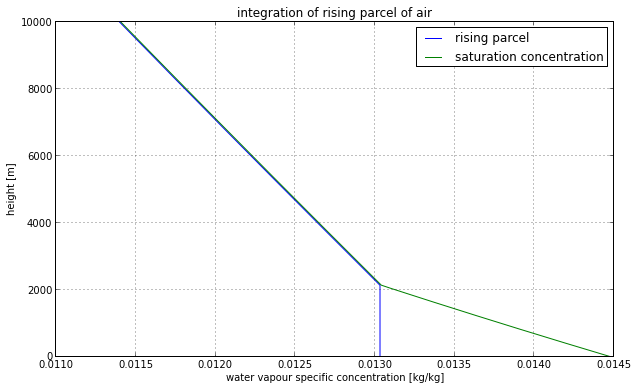

In [71]:
plot.figure(figsize=(10,6))
plot.plot(qv_, z_, label='rising parcel')
plot.plot(qv_sat(T=T_, p=p_), z_, label='saturation concentration')
plot.grid(True)
plot.xlabel('water vapour specific concentration [kg/kg]')
plot.ylabel('height [m]')
plot.title('integration of rising parcel of air')
plot.legend()